<img src = "https://i.imgur.com/UjutVJd.jpg"  align = "center">
<h1><font size = 5>GPU vs CPU</font></h1>

In this notebook we learn how to run a program on different devices.

There are usually multiple computing devices available on each machine. TensorFlow, supports three types of devices:
- "/cpu:0": The CPU of your machine.
- "/gpu:0": The GPU of your machine, if you have one.
- "/device:XLA:0": Optimized domain-specific compiler for linear algebra.

**Note: Use Change runtime  if  error occured, choose  Hardware Accelerator **

In [0]:
import sys
import numpy as np
import tensorflow as tf
from datetime import datetime
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.log_device_placement=False

### List of CPU and GPUs
How to get list of CPU and GPUs on your machine ?

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
get_available_gpus()

[u'/device:CPU:0',
 u'/device:XLA_CPU:0',
 u'/device:XLA_GPU:0',
 u'/device:GPU:0']

You might see one CPU, one or more GPUs if it is available on your computer, and also XLA.

#### Performance of GPU vs CPU
Most of Deep Learning models, especially in their training phase, involve a lot of matrix and vector multiplications that can parallelized. In this case, GPUs can overperform CPUs, because GPUs were designed to handle these kind of matrix operations in parallel!

#### Why GPU overperforms?
A single core CPU takes a matrix operation in serial, one element at a time. But, a single GPU could have hundreds or thousands of cores, while a CPU typically has no more than a few cores.


#### How to use GPU with TensorFlow?
It is important to notice that if both CPU and GPU are available on the machine that you are running a noebook, and if a TensorFlow operation has both CPU and GPU implementations, the GPU devices will be given priority when the operation is assigned to a device. 

In our case, as we are running this notebook on [IBM PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI), you hvae access to multi GPU, but lets use one of the GPUs in this notebook, for the sake of simplicity.

#### What is XLA?  
XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that optimizes TensorFlow computations. The results are improvements in speed, memory usage, and portability on server and mobile platforms. Initially, most users will not see large benefits from XLA, but are welcome to experiment by using XLA via just-in-time (JIT) compilation or ahead-of-time (AOT) compilation. Developers targeting new hardware accelerators are especially encouraged to try out XLA.

The XLA framework is experimental and in active development. In particular, while it is unlikely that the semantics of existing operations will change, it is expected that more operations will be added to cover important use cases. The team welcomes feedback from the community about missing functionality and community contributions via GitHub.

### Logging device

It is recommended to use __logging device placement__ when using GPUs, as this lets you easily debug issues relating to different device usage. This prints the usage of devices to the log, allowing you to see when devices change and how that affects the graph. Unfortunately, the currenct version of jupyter notbeook does not show the logs properly, but still you can print out the nodes as a json file and check the devices. It will work fine if your script is running outside of Jupyter though. 

You can see that a, b and c are all run on GPU0



In [3]:
def print_logging_device():
    # Creates a graph.
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.constant([1.0, 2.0, 3.0, 4.0, ], shape=[2, 2], name='c')
    mu = tf.matmul(a, b)
    # Creates a session with log_device_placement set to True.
    sess = tf.Session(config=config)
    # Runs the op.
    options = tf.RunOptions(output_partition_graphs=True)
    metadata = tf.RunMetadata()
    c_val = sess.run(mu, options=options, run_metadata=metadata)
    print (c_val)
    print (metadata.partition_graphs)

print_logging_device()

[[22. 28.]
 [49. 64.]]
[node {
  name: "MatMul"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:GPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
  experimental_debug_info {
    original_node_names: "MatMul"
  }
}
node {
  name: "MatMul/_0"
  op: "_Send"
  input: "MatMul"
  device: "/job:localhost/replica:0/task:0/device:GPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "client_terminated"
    value {
      b: false
    }
  }
  attr {
    key: "recv_device"
    value {
      s: "/job:localhost/replica:0/task:0/device:CPU:0"
    }
  }
  attr {
    key: "send_device"
    value {
      s: "/job:localhost/replica:0

#### What types of operations should I send to the GPU?

Basically, if a step of the process encompass “do this mathematical operation many times”, then it is a good candidate operation to send it to be run on the GPU. For example,
- Matrix multiplication 
- Computing the inverse of a matrix.
- Gradient calculation, which are computed on multiple GPUs individually and are averaged on CPU

### Device placement:
As mentioned, by default, GPU get priority for the operations which support runing on it. But, you can manually place an operation on a device to be run. You can use __ tf.device__ to assign the operations to a device context.

In [4]:
# Creates a new graph.
myGraph = tf.Graph()
with tf.Session(config=config, graph=myGraph) as sess:
    with tf.device('/gpu:0'):
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
        b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
        c = tf.constant([1.0, 2.0, 3.0, 4.0, ], shape=[2, 2], name='c')
        mu = tf.matmul(a, b)
    with tf.device('/cpu:0'):
        ad = tf.add(mu,c)
    print (sess.run(ad))

[[23. 30.]
 [52. 68.]]


Lets use one of Alex Mordvintsev deep dream [notebook]() to visualize the above graph. You can change the color to see the operations assigned to GPU and CPU.

In [5]:
# Helper functions for TF Graph visualization
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

graph_def = myGraph.as_graph_def()
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

### Multiplication on GPU and CPU
In teh following cell, we define a function, to measure the speed of matrix multiplication in CPU and GPU.

In [6]:
def matrix_mul(device_name, matrix_sizes):
    time_values = []
    #device_name = "/cpu:0"
    for size in matrix_sizes:
        with tf.device(device_name):
            random_matrix = tf.random_uniform(shape=(2,2), minval=0, maxval=1)
            dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
            sum_operation = tf.reduce_sum(dot_operation)

        with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as session:
            startTime = datetime.now()
            result = session.run(sum_operation)
        td = datetime.now() - startTime
        time_values.append(td.microseconds/1000)
        print ("matrix shape:" + str(size) + "  --"+ device_name +" time: "+str(td.microseconds/1000))
    return time_values


matrix_sizes = range(100,1000,100)
time_values_gpu = matrix_mul("/gpu:0", matrix_sizes)
time_values_cpu = matrix_mul("/cpu:0", matrix_sizes)
print ("GPU time" +  str(time_values_gpu))
print ("CPU time" + str(time_values_cpu))



matrix shape:100  --/gpu:0 time: 678
matrix shape:200  --/gpu:0 time: 6
matrix shape:300  --/gpu:0 time: 7
matrix shape:400  --/gpu:0 time: 7
matrix shape:500  --/gpu:0 time: 6
matrix shape:600  --/gpu:0 time: 6
matrix shape:700  --/gpu:0 time: 4
matrix shape:800  --/gpu:0 time: 7
matrix shape:900  --/gpu:0 time: 7
matrix shape:100  --/cpu:0 time: 13
matrix shape:200  --/cpu:0 time: 7
matrix shape:300  --/cpu:0 time: 8
matrix shape:400  --/cpu:0 time: 8
matrix shape:500  --/cpu:0 time: 8
matrix shape:600  --/cpu:0 time: 7
matrix shape:700  --/cpu:0 time: 7
matrix shape:800  --/cpu:0 time: 15
matrix shape:900  --/cpu:0 time: 8
GPU time[678, 6, 7, 7, 6, 6, 4, 7, 7]
CPU time[13, 7, 8, 8, 8, 7, 7, 15, 8]


Lets plot the results here. It clearly shows that GPU is faster than CPU

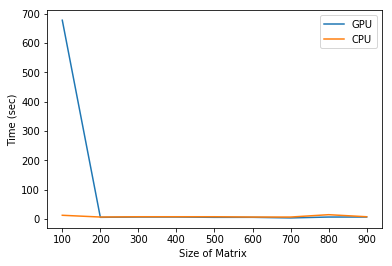

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot(matrix_sizes[:len(time_values_gpu)], time_values_gpu, label='GPU')
plt.plot(matrix_sizes[:len(time_values_cpu)], time_values_cpu, label='CPU')
plt.ylabel('Time (sec)')
plt.xlabel('Size of Matrix ')
plt.legend(loc='best')
plt.show()

#### When should not use GPU?

GPUs don’t have direct access to the rest of your computer (except, of course for the display). Due to this, if you are running a command on a GPU, you need to copy all of the data to the GPU first, then do the operation, then copy the result back to your computer’s main memory. TensorFlow handles this under the hood, so the code is simple, but the work still needs to be performed.


## Want to learn more?

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](https://cocl.us/DX0108EN-PowerAI).

### Thanks for completing this lesson!


<h3>Authors:</h3>
<article class="teacher">
<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://media.licdn.com/mpr/mpr/shrinknp_400_400/AAEAAQAAAAAAAAyFAAAAJGJlM2I2MmQzLTkxOWQtNDVhZi1hZGU0LWNlOWQzZDcyYjQ3ZA.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
<h4>Saeed Aghabozorgi</h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>
</article>
